# Model Training

In this colab notebook, we are training our heatmap model. We will first preprocess the input image using inception_v3 into a vector representation with 2048 attributes. Using this vector, we attempt to define a model that decodes the vector into the heatmap corresponding to this particular image

## Import Packages

In [0]:
from google.colab import drive
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

In [0]:
drive.mount('/gdrive')
train_path = '/gdrive/My Drive/train_data/level_2/images/'
#train_path = '/gdrive/My Drive/images/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Divide dataset into training and testing

A couple of things to note:
- Make sure the zipped activations and masks are in the colab directory

In [0]:
!cp /gdrive/My\ Drive/train_data/level_2/masks.zip /content/masks.zip
!cp /gdrive/My\ Drive/train_data/level_2/activationss.zip /content/activation.zip
!unzip /content/masks.zip
!unzip /content/activation.zip

Archive:  /content/mask.zip
  inflating: masks/train_mask_17986.png  
  inflating: masks/train_mask_17988.png  
  inflating: masks/train_mask_17979.png  
  inflating: masks/train_mask_17983.png  
  inflating: masks/train_mask_17985.png  
  inflating: masks/train_mask_17977.png  
  inflating: masks/train_mask_17834.png  
  inflating: masks/train_mask_18000.png  
  inflating: masks/train_mask_17984.png  
  inflating: masks/train_mask_17991.png  
  inflating: masks/train_mask_17978.png  
  inflating: masks/train_mask_17890.png  
  inflating: masks/train_mask_17996.png  
  inflating: masks/train_mask_17990.png  
  inflating: masks/train_mask_17982.png  
  inflating: masks/train_mask_17994.png  
  inflating: masks/train_mask_17981.png  
  inflating: masks/train_mask_17987.png  
  inflating: masks/train_mask_17999.png  
  inflating: masks/train_mask_17938.png  
  inflating: masks/train_mask_17920.png  
  inflating: masks/train_mask_17943.png  
  inflating: masks/train_mask_17932.png  
  infl

In [0]:
from sklearn.model_selection import train_test_split

activations_path = '/content/activations'
masks_path = '/content/masks'

files = os.listdir(masks_path)
#files.remove("train_mask_3785.png")
activation_inputs = []
mask_outputs = []
for filename in files:
  activation_file = filename.split("mask_")[0] + filename.split("mask_")[1] + '.npy'
  activation_inputs.append(os.path.join(activations_path, activation_file))
  mask_outputs.append(os.path.join(masks_path, filename))

X_train, X_test, y_train, y_test = train_test_split(activation_inputs, mask_outputs, train_size=0.8)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.5)

## Defining our model

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, Input, Flatten
from tensorflow.keras.models import Sequential, Model

decoder_input = Input(shape=(2048,))

x = Dense(625, activation='relu')(decoder_input)

x = Reshape((25, 25, 1))(x)

x = Conv2DTranspose(64, 3,
                    padding='same',
                    activation='relu',
                    strides=(2,2))(x)

x = Conv2DTranspose(64, 3,
                    padding='same',
                    activation='relu',
                    strides=(2,2))(x)

x = Conv2DTranspose(32, 3,
                    padding='same',
                    activation='relu',
                    strides=(2,2))(x)

x = Conv2DTranspose(32, 3,
                    padding='same',
                    activation='relu',
                    strides=(2,2))(x)
                    

x = Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder_model = Model(decoder_input, x)


In [0]:
print(decoder_model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense (Dense)                (None, 625)               1280625   
_________________________________________________________________
reshape (Reshape)            (None, 25, 25, 1)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 50, 50, 64)        640       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 100, 100, 64)      36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 200, 200, 32)      18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 400, 400, 32)      9248

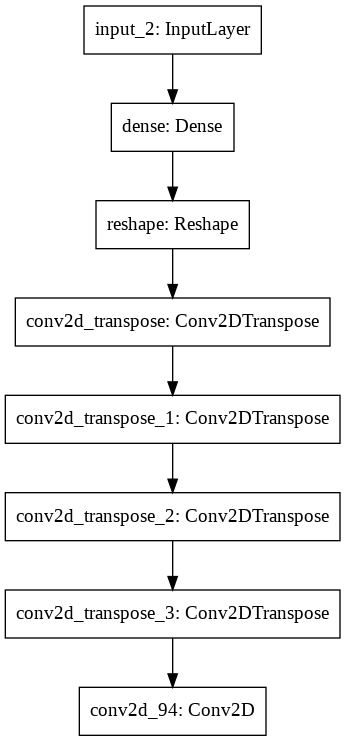

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(decoder_model, to_file='model.png')

In [0]:
decoder_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

## Model Training

In [0]:
drive_root = '/gdrive/My Drive/'
checkpoint_dir = os.path.join(drive_root, "checkpoints")
checkpoint_dir = os.path.join(checkpoint_dir, "Final_project")

checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}.ckpt")

In [0]:
print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir)

Checkpoints directory is /gdrive/My Drive/checkpoints/Final_project
Checkpoints folder already exists


In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.BinaryCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

In [0]:
def evaluate(max_steps=None):
  steps = 0
  for i in range(len(X_val)):
    inp = np.load(X_val[i])
    ans = np.array(Image.open(y_val[i]).convert('L'))[:400,:400]
    norm_ans = (ans-30)/(215-30)
    predictions = decoder_model.predict(inp.reshape(1,2048))
    
    steps += 1 
    ans = norm_ans.reshape(1,400,400,1)
    
    val_loss(ans, predictions)
    val_accuracy(ans, predictions)

In [0]:
import time 

train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 5 

for epoch in range(epochs):

  start = time.time()

  for j in range(525):
    elements = np.random.randint(len(X_train), size=32)
    X_batch, y_batch = [], []
    for e in elements:   
      X_batch.append(np.load(X_train[e]))
      mask_img = np.array(Image.open(y_train[e]).convert('L'))[:400,:400]
      norm_img = (mask_img-30)/(215-30)
      y_batch.append(norm_img)
    result = decoder_model.train_on_batch(np.array(X_batch), np.array(y_batch))

    train_loss(result[0])
    train_accuracy(result[1])

  evaluate(max_steps=100)

  template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        time.time() - start))
  
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)

  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  print("Saving weights")
  decoder_model.save_weights(checkpoint_dir)

Epoch 0, Loss: 0.11, Accuracy: 96.16, Val Loss 0.10, Val Accuracy 95.55, Time: 186.2 secs
Saving weights
Epoch 1, Loss: 0.08, Accuracy: 96.40, Val Loss 0.09, Val Accuracy 96.02, Time: 179.6 secs
Saving weights
Epoch 2, Loss: 0.07, Accuracy: 96.63, Val Loss 0.10, Val Accuracy 96.07, Time: 178.9 secs
Saving weights
Epoch 3, Loss: 0.07, Accuracy: 96.77, Val Loss 0.09, Val Accuracy 95.91, Time: 176.4 secs
Saving weights
Epoch 4, Loss: 0.06, Accuracy: 96.90, Val Loss 0.09, Val Accuracy 95.84, Time: 176.8 secs
Saving weights


In [0]:
decoder_model.save('model.h5')

In [0]:
!cp model.h5 /gdrive/My\ Drive/train_data/level_2/

In [0]:
decoder_model.load_weights('model.h5')

/content/activations/train_11067.png.npy


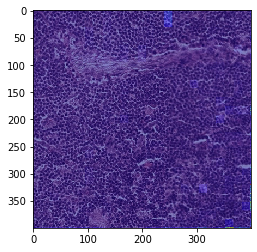

In [0]:
img = np.array(Image.open(os.path.join(train_path,'train_11067.png')))[:400,:400]
inp = np.load(X_test[9])
print(X_test[9])
ans = np.array(Image.open(y_test[9]).convert('L'))[:400,:400]
norm_ans = (ans-30)/(215-30)
predictions = decoder_model.predict(inp.reshape(1,2048)).reshape(400,400)

#print(img.shape)
#print(predictions)
plt.imshow(img)
plt.imshow(predictions, cmap='jet', alpha=0.5)
plt.show()

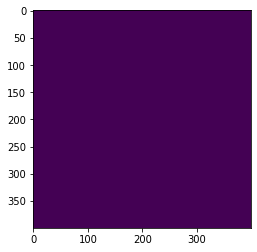

In [0]:
true_mask = Image.open(os.path.join(masks_path,'train_mask_11067.png'))
plt.imshow(true_mask)